In [1]:
import torch
import pandas as pd
import numpy as np
import random

import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
tempDf = pd.read_csv('Dataset-Indian-Names-master/Indian-Male-Names.csv')
namesList = tempDf['name'][tempDf['name'].notna()].tolist()
tempDf = pd.read_csv('Dataset-Indian-Names-master/Indian-Female-Names.csv')
namesList.extend(tempDf['name'][tempDf['name'].notna()].tolist())

In [3]:
namesList = namesList + open('Dataset-Indian-Names-master/names.txt', 'r').read().splitlines()

In [4]:
uniqueChar = set()
for name in namesList:
        for char in name:
            uniqueChar.add(char)


In [5]:
startChar = '<S>'
endChar = '<E>'
uniqueChar.add(startChar)
uniqueChar.add(endChar)
print(f'Total names :- {len(namesList)}')
print(f'Total unique characters :- {len(uniqueChar)}')

Total names :- 62205
Total unique characters :- 99


In [6]:
namesList[-5:] + namesList[:5]

['zylas',
 'zyran',
 'zyrie',
 'zyron',
 'zzyzx',
 'barjraj',
 'ramdin verma',
 'sharat chandran',
 'birender mandal',
 'amit']

In [7]:
def generate_batch(dataset, batch_size):
    while True:
        random.shuffle(dataset)
        for i in range(0, len(dataset), batch_size):
            yield dataset[i: i+batch_size]
            

In [8]:
class MLP:
    def __init__(self, input_size, layer_size, output_size, has_bias = False):
        self.layer1 = torch.randn(input_size, layer_size)
        self.layer2 = torch.randn(layer_size, output_size)
        self.bias2 = torch.randn(output_size)
        self.scale_factor = torch.ones(1, layer_size)
        self.shift = torch.zeros(1, layer_size)
        
        self.layer1.requires_grad = True
        self.layer2.requires_grad = True
        self.scale_factor.requires_grad = True
        self.shift.requires_grad = True
        
        
    def forward(self, input_tensor):
        layer_out = input_tensor @ self.layer1
        mean = layer_out.mean(dim = 0, keepdim = True)
        variance = layer_out.var(dim = 0, keepdim = True)
        layer_out = self.scale_factor * (layer_out - mean)/(variance**0.5 + 1e-7) + self.shift
        layer_out = F.tanh(layer_out)
        layer_out = layer_out @ self.layer2 + self.bias2
        return layer_out
    
    def get_parameters(self):
        parameters = [self.layer1, self.layer2, self.bias2, self.scale_factor, self.shift]
        return parameters
    
    def flush_gradients(self):
        parameters = self.get_parameters()
        for p in parameters:
            p.grad = None
    
    def apply_gradients(self, lr):
        parameters = self.get_parameters()
        for p in parameters:
            if p.grad is not None:
                p.data -= lr * p.grad
        

In [9]:
class Embedding:
    def __init__(self, embedding_size, vocab_size):
        self.embedding_lookup = {}
        for token in range(vocab_size):
            self.embedding_lookup[token] = torch.randn(embedding_size)
            self.embedding_lookup[token].requires_grad = True
            
    def forward(self, input_token):
        if type(input_token) is list:
            output = []
            for token in input_token:
                output.append(self.embedding_lookup[token])
            return output
        
        return self.embedding_lookup[input_token]
    
    def get_parameters(self):
        parameters = []
        for key in self.embedding_lookup:
            parameters.append(self.embedding_lookup[key])
        return parameters
    
    def flush_gradients(self):
        parameters = self.get_parameters()
        for p in parameters:
            p.grad = None
            
    def apply_gradients(self, lr):
        parameters = self.get_parameters()
        for p in parameters:
            if p.grad is not None:
                p.data -= lr * p.grad


In [24]:
sequence_size = 8
all_sequences = []
for name in namesList:
    sequence = []
    for i in range(sequence_size+1):
        sequence += [startChar]
    for i in range(len(name)+1):
        if i == len(name):
            char = endChar
        else:
            char = name[i]
        sequence = sequence[1:] + [char]
        all_sequences.append(sequence)

In [25]:

embedding_size = 15
layer_size = 200

char_to_idx_map = {}
idx_to_char_map = {}
idx = 0

for char in uniqueChar:
    char_to_idx_map[char] = idx
    idx_to_char_map[idx] = char
    idx+=1

char_embedding = Embedding(embedding_size, len(uniqueChar))
model = MLP(embedding_size * sequence_size, layer_size, len(uniqueChar))
parameters = [char_embedding, model]
loss_arr = []

In [26]:
num_iterations = 200000
batch_size = 32
idx = 0  

batch_generator = generate_batch(all_sequences, batch_size)
for i in range(num_iterations):
    for p in parameters:
        p.flush_gradients()
    
    idx += 1
    batch = next(batch_generator)
    X = []
    Y = []
    for row in batch:
        input_sequence = row[:-1]
        next_char = row[-1]
        input_embedding = char_embedding.forward([char_to_idx_map[char] for char in input_sequence])
        ohe = F.one_hot(torch.tensor(char_to_idx_map[next_char]), len(uniqueChar))
        X.append(torch.cat(input_embedding))
        Y.append(ohe)
        
    X = torch.stack(X)
    Y = torch.stack(Y)
    # print(X)
    # print("------")
    # print(X.shape)
    output = model.forward(X)
    
    # print(output.shape)
    # print(Y.shape)
    # print(Y[0])
    # print(output)
    # break
    loss = F.cross_entropy(output, Y.float())
    loss_arr.append(loss.log10().item())
    
    if idx < 100000:
        lr = 0.1
        
    elif idx < 150000:
        lr = 0.01
    else:
        lr = 0.002
        
    loss.backward()
    for p in parameters:
        p.apply_gradients(lr)
        
    if idx % 5000 == 0:
        print(idx, " : ", np.mean(loss_arr[-1000:]), " ", 10**np.mean(loss_arr[-1000:]))
    

5000  :  0.43266974824666976   2.708131496773214
10000  :  0.41079887437820434   2.5751283160811744
15000  :  0.4000592162758112   2.512228951866372
20000  :  0.39401897087693216   2.477530278891997
25000  :  0.3887289659976959   2.447535310089411
30000  :  0.38502214847505095   2.4267338523160307
35000  :  0.3790310778319836   2.3934870266595194
40000  :  0.37881170777976514   2.392278338062969
45000  :  0.3732568781226873   2.361874830656353
50000  :  0.3713267930150032   2.3514015114195708
55000  :  0.36792445757985115   2.333052209232714
60000  :  0.3634307310730219   2.3090361438271882
65000  :  0.367023697450757   2.3282182943542695
70000  :  0.3645123767852783   2.3147941534708756
75000  :  0.36196045377850533   2.3012322610175895
80000  :  0.3611896738409996   2.2971516874554427
85000  :  0.35720740485936403   2.276184202477058
90000  :  0.35512659734487534   2.2653045502597995
95000  :  0.3553436737805605   2.26643711623625
100000  :  0.3543277638852596   2.2611416195931375
10

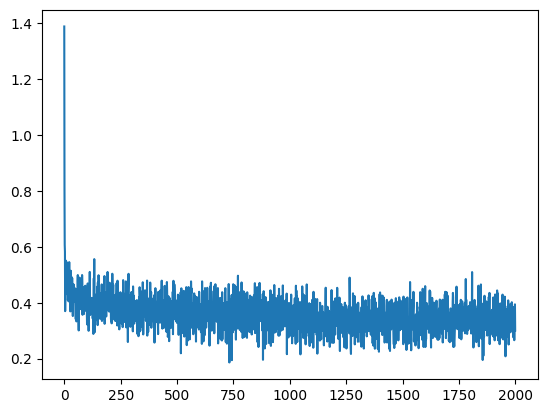

In [27]:
sampled_data = loss_arr[::100]  # Adjust the step for sampling as needed
plt.plot(sampled_data)

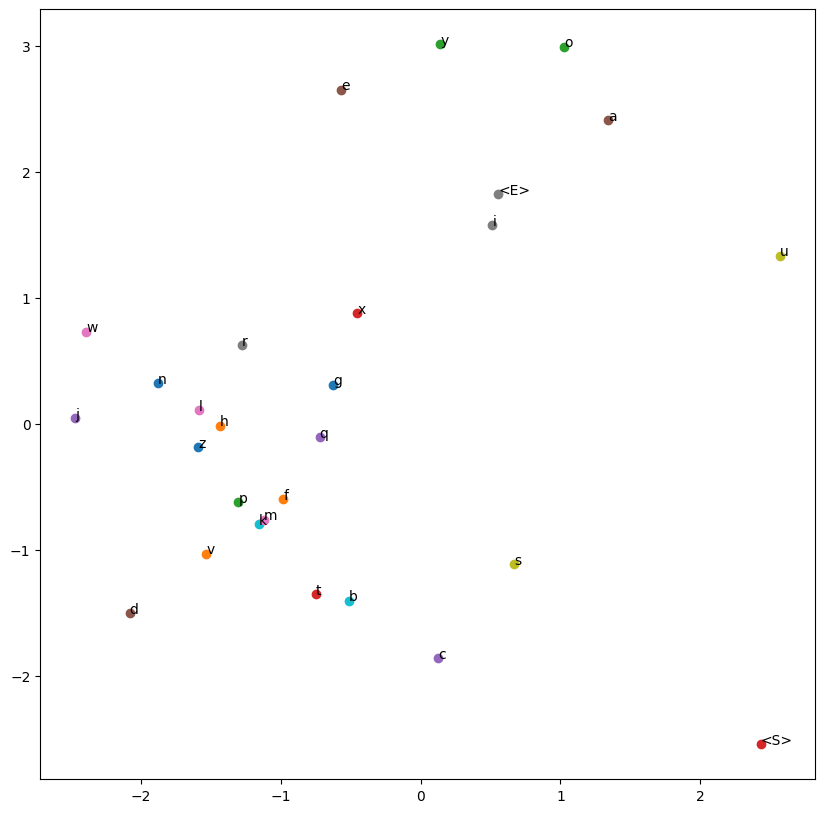

In [28]:
## For embeddings greater than 2, supress data to 2 dimensions
embeddings = []
chars = []

for char in uniqueChar:
    idx = char_to_idx_map[char]
    embeddings.append(char_embedding.forward(idx))
    chars.append(char)

embedding_tensor = torch.stack(embeddings)

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_tensor.detach().numpy())

# Plot
plt.figure(figsize=(10, 10))
for i, char in enumerate(chars):
    if (char.isascii() and char.isalpha()) or char == startChar or char == endChar:
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
        plt.annotate(char, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))


In [29]:
def next_char_generate(sequence):
    sequence = sequence[-sequence_size:]
    input_tensor = []
    for char in sequence:
        input_tensor.append(char_embedding.forward(char_to_idx_map[char]))
    input_tensor = torch.cat(input_tensor)
    out = model.forward(input_tensor)
    # print(out)
    # Sample an index, treating the tensor's values as probabilities
    sampled_index = torch.multinomial(F.softmax(out), num_samples=1).item()
    return idx_to_char_map[sampled_index]

In [30]:
start_sequence = []
for i in range(sequence_size):
    start_sequence.append(startChar)

In [31]:
def gen_name(sequence):
    name = ''
    for char in sequence:
        if char != startChar:
            name += char
    while True:
        # print(sequence)
        next_char = next_char_generate(sequence)
        # print(next_char)
        sequence = sequence[1:] + [next_char]
        if next_char == endChar:
            break
        name += next_char
        
    return name

In [36]:
names = []
for i in range(10):
    names.append(gen_name(start_sequence))
names

/var/folders/74/h39_kcwj7_j6r865dqfty2cc0000gn/T/ipykernel_19299/3507051933.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sampled_index = torch.multinomial(F.softmax(out), num_samples=1).item()


['lolia',
 'reina',
 'amsisankamaligot pangali',
 'amallain',
 'ninabrismelta',
 'rushriqhithu penis',
 'sanirras',
 'melrandalai',
 'amrlynchanj',
 'imanaman']

In [37]:
prefix = ['a', 'd']
resList = []
for i in range(10):
    while(len(prefix) < sequence_size):
        prefix = ['<S>'] + prefix
    resList.append(gen_name(prefix))
    
resList

/var/folders/74/h39_kcwj7_j6r865dqfty2cc0000gn/T/ipykernel_19299/3507051933.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sampled_index = torch.multinomial(F.softmax(out), num_samples=1).item()


['adenna',
 'adrisrankale',
 'adhirah sharan',
 'addercelgmrefrenu',
 'adeishahelhali',
 'adena',
 'adaiyazinsr',
 'aderiakishnelighy',
 'adamlee',
 'adriora']